<a href="https://colab.research.google.com/github/David-Smirnoff/NN_Classif_Hand_Hygiene/blob/main/5_sensores_R_Forest_Classification_Hand_hygiene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import warnings
import os
import json
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from numpy import array
from numpy.linalg import norm
%matplotlib widget
warnings.filterwarnings('ignore')

In [ ]:
from sklearn import metrics
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers,layers

In [ ]:

# Specify the path to your JSON file
json_file_path1 = r'C:\Users\Win10\Desktop\I C\Programas\NN\Data Higiene de manos\train.json'
json_file_path2= r'C:\Users\Win10\Desktop\I C\Programas\NN\Data Higiene de manos\validation.json'
json_file_path3 = r'C:\Users\Win10\Desktop\I C\Programas\NN\Data Higiene de manos\test.json'

# Open the JSON file and load its contents
#TRAIN
with open(json_file_path1, 'r') as file:
    df_train = json.load(file)
df_train = pd.DataFrame.from_dict(df_train)
df_train = df_train.rename(columns={'event_classifier': 'Class'})
sub_columns_train = pd.DataFrame(df_train['Timestamps'].to_dict()).columns  #Access the sub-column names train

#VALIDATION
with open(json_file_path2, 'r') as file:
    df_validation = json.load(file)
df_validation = pd.DataFrame.from_dict(df_validation)
df_validation = df_validation.rename(columns={'event_classifier': 'Class'})
sub_columns_validation = pd.DataFrame(df_validation['Timestamps'].to_dict()).columns  #Access the sub-column names validation

#TEST
with open(json_file_path3, 'r') as file:
    df_test = json.load(file)
df_test = pd.DataFrame.from_dict(df_test)
df_test = df_test.rename(columns={'event_classifier': 'Class'})
sub_columns_test= pd.DataFrame(df_test['Timestamps'].to_dict()).columns  #Access the sub-column names test

# Concatenate the DataFrames in order
df = pd.concat([df_train, df_validation, df_test])
mean_columns=df.columns   # Access the mean-column names. All the mean columns are the same   AKA: the sensors names
sub_columns = pd.DataFrame(df['Timestamps'].to_dict()).columns  #Access the sub-column names  AKA: the events

events_quantity=len(df[mean_columns[5]])
points_quantity=len(df['Timestamps'][sub_columns[0]])
sensor_quantity=len(mean_columns)

print(sensor_quantity,points_quantity,events_quantity, mean_columns)

13 60 517 Index(['Timestamps', 'sgp30_EtOH_[au]', 'sgp30_H2_[au]', 'tgs8100_R_[Ohms]',
       'tgs2600_R_[Ohms]', 'ccs811_R_[Ohms]', 'tag_R_[Ohms]', 'temp_[C]',
       'rh_[%]', 'time_last_event_[s]', '#events_last1h', '#events_last2h',
       'Class'],
      dtype='object')



![separador](https://i.imgur.com/4gX5WFr.png)

# Características:
##### 13 Sensores/// 517 eventos/// Intervalos de tiempo de 300 seg, tomados cada 5 seg (60 features)

![Captura de pantalla 2023-06-09 093808.png](<attachment:Captura de pantalla 2023-06-09 093808.png>)

![separador](https://i.imgur.com/4gX5WFr.png)


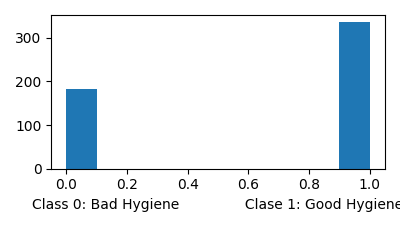

In [ ]:
plt.figure(figsize=(4,2.27))
plt.hist(df['Class'])  #Bins es el ancho de la columna
plt.xlabel("Class 0: Bad Hygiene               Clase 1: Good Hygiene")
plt.tight_layout()
plt.show()

![separador](https://i.imgur.com/4gX5WFr.png)

### Aumento Clase 2
![separador](https://i.imgur.com/4gX5WFr.png)


Cada clase tiene elementos: 182 335
Ahora cada clase tiene elementos: 282 335


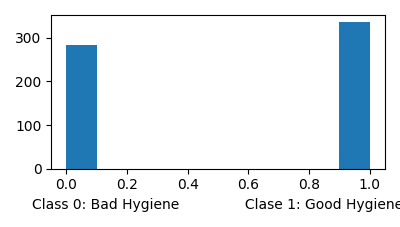

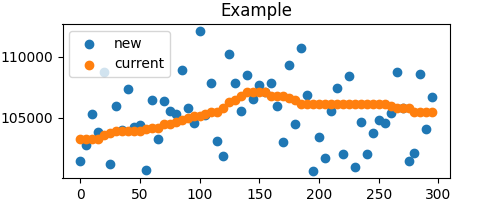

In [ ]:
df_class0 = df[df['Class'] == 0]
df_class1 = df[df['Class'] == 1]
print('Cada clase tiene elementos:',len(df_class0),len(df_class1))
# Numero para balancear la data
selected_sensors=['sgp30_EtOH_[au]', 'sgp30_H2_[au]', 'tgs8100_R_[Ohms]', 'tgs2600_R_[Ohms]', 'ccs811_R_[Ohms]', 'tag_R_[Ohms]', 'temp_[C]','rh_[%]']
# Creo un DataFrame para almacenar la data balanceada
balanced_df = pd.DataFrame(columns=df.columns)

aumento=100
for buf in range(0,aumento):
    # Copy the row
    new_row = df_class0.sample(n=1)
    current_row=new_row.copy()
    # Add Gaussian noise to selected features
    for sensor in selected_sensors:
        noise=np.random.normal(0,0.025,points_quantity)
        new_row[sensor][0] =[x *(1+ y) for x, y in zip(new_row[sensor][0], noise)]
    if buf==60:
        plt.figure(figsize=(5,2))
        t=np.arange(0, points_quantity * 5, 5)
        for sensor in range(2,3):
            plt.scatter(t,new_row[mean_columns[5]][0],label='new')
            plt.scatter(t,current_row[mean_columns[5]][0],label='current')
            plt.title('Example')
            plt.xlabel('t [s]')
            plt.legend()
    # Append the modified row to the balanced data frame
    balanced_df = balanced_df.append(new_row, ignore_index=True)

# Concatenate the balanced class 2 data frame with the original class 1 data frame
balanced_df = pd.concat([df, balanced_df], axis=0,ignore_index=True)
balanced_df = balanced_df.sample(frac=1)#, random_state=42)  # frac=1 shuffles all rows, random_state for reproducibility

df_class0= balanced_df[balanced_df['Class'] == 0]
df_class1 = balanced_df[balanced_df['Class'] == 1]
mean_columns2=balanced_df.columns   # Access the mean-column names. All the mean columns are the same   AKA: the sensors names
sub_columns2 = pd.DataFrame(balanced_df['Timestamps'].to_dict()).columns  #Access the sub-column names  AKA: the events
events_quantity=len(balanced_df[mean_columns[5]])
points_quantity=len(balanced_df['Timestamps'][sub_columns2[0]])

print('Ahora cada clase tiene elementos:',len(df_class0) , len(df_class1))
plt.figure(figsize=(4,2.27))
plt.hist(balanced_df['Class'])  #Bins es el ancho de la columna
plt.xlabel("Class 0: Bad Hygiene               Clase 1: Good Hygiene")
plt.tight_layout()
plt.show()
# print(sensor_quantity,points_quantity,events_quantity, mean_columns)


![separador](https://i.imgur.com/4gX5WFr.png)

# Sensores:

##### Estacionarios: SGP30_EtOH (arbitrary units); SGP30_H2 (a.u.); TGS8100 R (Ω); TGS2600 R (Ω); CCS811 R (Ω)
##### HYT939 Temperature/ humidity  T (◦C) r.h. (%) stationary
##### Portable: TGS8100 R (Ω) tag   <span style="color:red">No me va a importar.</span>
![separador](https://i.imgur.com/4gX5WFr.png)


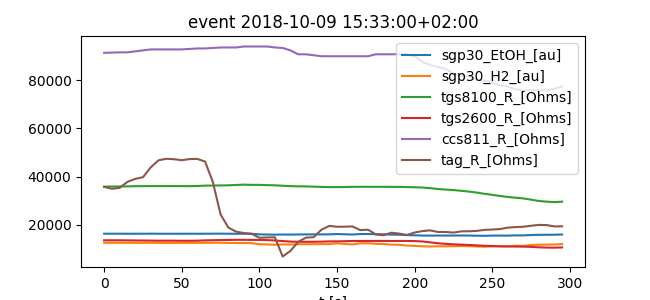

In [ ]:
#sensor=1  #(0<=sensor<=8)
event=np.arange(0,616,1); t=np.arange(0, points_quantity * 5, 5);   #choose event;
event=294
plt.figure(figsize=(6.5, 3))
for sensor in range(1,7):
    plt.plot(t,balanced_df[mean_columns[sensor]][sub_columns2[event]],label=f'{mean_columns[sensor]}')
plt.title(f'event {balanced_df[mean_columns[0]][sub_columns2[event]][0]}')
plt.xlabel('t [s]')
plt.legend()

![separador](https://i.imgur.com/4gX5WFr.png)

# Random Forest

![separador](https://i.imgur.com/4gX5WFr.png)


##### Defino PlotLoss, PlotAcc, Plot_Conf_Matrix

In [ ]:
def plotLoss(result, extra_title=""):
    loss = result.history['loss']
    val_loss = result.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(4,4))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss '+extra_title)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Square Error')
    plt.legend()
    plt.show()

def plotAcc(result, extra_title=""):
    acc = result.history['sparse_categorical_accuracy']
    val_acc = result.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(4,4))
    plt.plot(epochs, acc, 'y', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation acc '+extra_title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

def plot_conf_matrix(results, X, Y, extra_title=""):
    cm = metrics.confusion_matrix(Y, results)
    print(cm)
    plt.figure(1)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['B Hygiene','G Higyene'])
    disp.plot()
    plt.title("Matriz de confusion "+extra_title)
    plt.show()


In [ ]:
# Resume
selected_sensor = mean_columns[1:6]
selected_sensor = selected_sensor.tolist()
print(selected_sensor)
Y = balanced_df["Class"]
Y = Y.astype(np.int64) # Convert target variable to a compatible data type

X = None  # Initialize X as None

for sensor in selected_sensor:
    x_curr = balanced_df[sensor]  # Access the current sensor column
    x_curr = pd.DataFrame(x_curr.tolist())
    scaler = StandardScaler().fit(x_curr)
    x_curr = scaler.transform(x_curr)
    #print('x_curr:',x_curr[0:2])
    if X is None:
        X = x_curr
    else:
        X = np.concatenate((X, x_curr), axis=1)
print(X.shape,type(X),Y.shape,type(Y))



# Convert Y to a numpy array
Y = Y.values
# Set the number of samples to extract
num_samples = 10
# Get the indices of the samples to extract randomly
sample_indices = np.random.choice(X.shape[0], size=num_samples, replace=False)
# Extract the samples and their corresponding labels
final_test_X = X[sample_indices]
final_test_Y = Y[sample_indices]
# Drop the rows from the original X and Y
X = np.delete(X, sample_indices, axis=0)
Y = np.delete(Y, sample_indices)
print(X.shape,type(X),Y.shape,type(Y))
print(final_test_Y)


['sgp30_EtOH_[au]', 'sgp30_H2_[au]', 'tgs8100_R_[Ohms]', 'tgs2600_R_[Ohms]', 'ccs811_R_[Ohms]']
(617, 300) <class 'numpy.ndarray'> (617,) <class 'pandas.core.series.Series'>
(607, 300) <class 'numpy.ndarray'> (607,) <class 'numpy.ndarray'>
[1 1 1 0 1 0 0 0 1 0]


![separador](https://i.imgur.com/4gX5WFr.png)
## Random Forest
##### n_estimators: Number of trees in the random forest
##### max_depth: Maximum depth of each tree
##### min_samples_split: Minimum number of samples required to split a node
##### oob_score: OOB (Out Of the Bag) is a random forest cross-validation method. In this, one-third of the sample is not used to train the data but to evaluate its performance.
##### criterion='entropy'
![separador](https://i.imgur.com/4gX5WFr.png)

The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Precisión: 0.90
0 Matriz de confusión:
[[23  2]
 [ 4 32]]


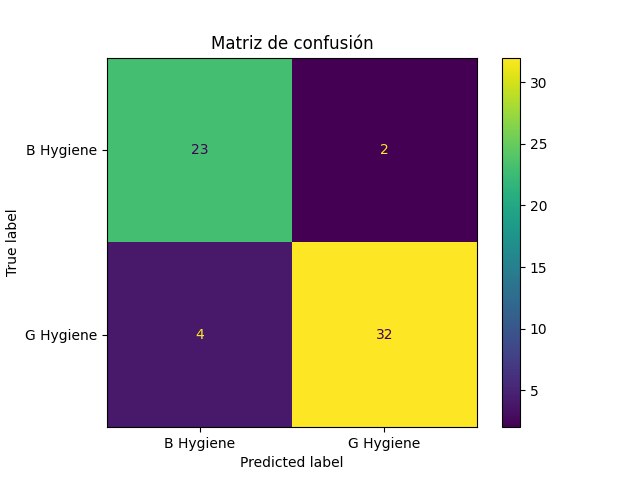

[0.9016393442622951]
Mean: Standard Deviation: 90 0.0


In [ ]:
Accuracy=[]
n=1
for k in range(0,n):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
    # Crear un model de Random Forest con 200 árboles, max_depth=10, min_samples_split=2
    model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=3)

    # Entrenar el model con los datos de entrenamiento
    result=model.fit(X_train, y_train)
    # Predecir las clases del conjunto de prueba
    y_pred = model.predict(X_test)

    # Calcular la precisión del model
    accuracy = accuracy_score(y_test, y_pred); Accuracy.append(accuracy)
    print('Precisión: {:.2f}'.format(accuracy))

    # Obtener la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print(k,'Matriz de confusión:') ;print(cm)
    # Visualizar la matriz de confusión
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['B Hygiene', 'G Hygiene'])
    disp.plot()
    plt.title("Matriz de confusión")
    plt.show()

mean = np.mean(Accuracy)
std_dev = np.std(Accuracy)
print(Accuracy)
print("Mean:", "Standard Deviation:" ,f"{mean*100:.0f}",f"{ std_dev*100:.1f}")
#### 85 3.7  con n_estimators=200, max_depth=10, min_samples_split=2/8/30
####  86 4.6 con n_estimators=1000, max_depth=10, min_samples_split=5                       con  arboles<100 da alrededor de 80

Accuracy: 1.0
Confusion Matrix:
[[5 0]
 [0 5]]


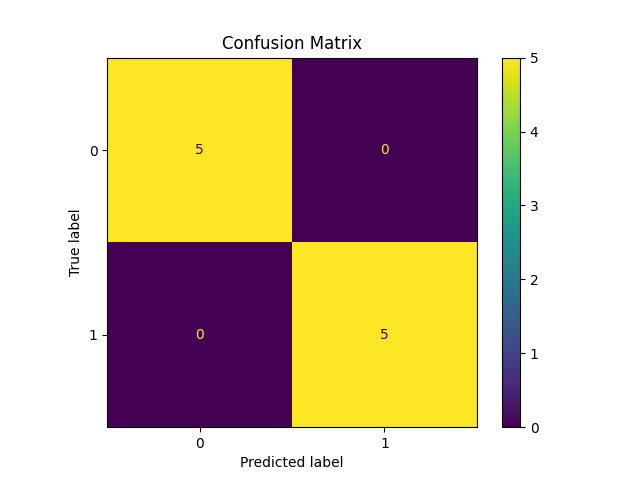

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Make predictions on the extracted samples
predictions = model.predict(final_test_X)
cm = confusion_matrix(final_test_Y, predictions)
accuracy = accuracy_score(final_test_Y, predictions)

print('Accuracy:', accuracy) # Print the accuracy
print('Confusion Matrix:'); print(cm) # Print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Visualize the confusion matrix
disp.plot(); plt.title("Confusion Matrix"); plt.show()

### Whit OBB

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification
# from sklearn.metrics import accuracy_score, confusion_matrix
# import numpy as np

# n = 10  # Number of OBB iterations
# accuracy_list = []

# for k in range(n):
#     # Create a random forest classifier
#     model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=2, oob_score=True)

#     # Train the model and compute OBB accuracy
#     model.fit(X, Y)
#     accuracy = model.oob_score_
#     accuracy_list.append(accuracy)

#     print('OBB Accuracy: {:.2f}'.format(accuracy))

#     # Predict the classes using out-of-bag samples
#     y_pred = model.predict(X)

#     # Compute accuracy using the out-of-bag samples
#     #oob_accuracy = accuracy_score(Y, y_pred)
#     #print('Out-of-Bag Accuracy: {:.2f}'.format(oob_accuracy))

#     # Compute and display the confusion matrix
#     cm = confusion_matrix(Y, y_pred)
#     print('Confusion Matrix:')
#     print(cm)

# mean_accuracy = np.mean(accuracy_list)
# std_deviation = np.std(accuracy_list)

# print('OBB Accuracy List:', accuracy_list)
# print('Mean OBB Accuracy: {:.2f}'.format(mean_accuracy))
# print('Standard Deviation of OBB Accuracy: {:.2f}'.format(std_deviation))
